<a href="https://colab.research.google.com/github/Ran147/Project_T/blob/main/Final_ver_FR_face_recognition__estudiantes_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [1]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
!pip install pytz
import datetime
import pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=a1fd61aa15c44a583295d5aafcc78b19dfaa1b55b7389060682662f13227f49e
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


# Utils

## In-memory data

In [2]:
registered_faces = {}
registered_professor = []
registered_student = []
registered_miscelaneous = []
registered_class = []
registered_course = []
registered_attendance = []
registered_students_in_courses = []

In [32]:
attendance_list0 = []
attendance_list2 = []
attendance_list3 = []

##Save info

In [4]:
local_tz = pytz.timezone('America/Costa_Rica')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## face recognition

In [5]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [7]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register profesor, student, miscelaneous, classroom and course

## Registrar rostro de profesores

In [8]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de profesores

In [9]:

def profesor():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    # Ask the user for a phone number
    print("")
    phone_number = input("Enter phone number: ")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    print("")
    another = input("Do you want to add another phone number? (yes/no): ")

    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    email_list.append(email)
    print("")
    another_email = input("Do you want to add another email? (yes/no): ")
    if another_email != "yes":
      break
  print("")
  address = input("Address: ")
  print("")
  specialty = input("Specialty: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  print("")
  teacher = {'name': registered_name, 'id': id, 'age': age, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'specialty': specialty,
            'matiral status': marital_status}
  registered_professor.append(teacher)


profesor()

Enter the identification: 8588586

Birthday: 73736
Age: 36

Nationality: Argentinian

Enter contact name: msus

Enter phone number: 477488

Do you want to add another phone number? (yes/no): no

Enter an email address: messias@gmail.com

Do you want to add another email? (yes/no): no

Address: sididnid

Specialty: Dribbles

Marital status: Married




In [10]:
print(registered_professor)

[{'name': 'Messi', 'id': '8588586', 'age': 36, 'Birthday': '73736', 'nationality': 'Argentinian', 'Phone book': {'msus': '477488'}, 'emails': ['messias@gmail.com'], 'address': 'sididnid', 'specialty': 'Dribbles', 'matiral status': 'Married'}]


## Registrar rostro de estudiantes

In [13]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)



### Registrar informacion de estudiantes

In [14]:

def estudiante():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    print("")
    # Ask the user for a phone number
    phone_number = input("Enter phone number: ")
    print("")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")

    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    email_list.append(email)
    print("")
    another_email = input("Do you want to add another email? (yes/no): ")
    if another_email != "yes":
      break
  print("")
  address = input("Adress")
  print("")
  carreer = input("Carreer: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  student = {'name': registered_name, 'id': id, 'age': age, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'carreer': carreer,
            'matiral status': marital_status}
  registered_student.append(student)


estudiante()

Enter the identification: 36362627

Birthday: 83874
Age: 28

Nationality: Portugues

Enter contact name: jsjdb

Enter phone number: 82626637

Do you want to add another phone number? (yes/no): no

Enter an email address: sjjeie@gmail.com

Do you want to add another email? (yes/no): no

Adressjdhdhdhe

Carreer: Ing computacion

Marital status: Married



In [15]:
print(registered_student)

[{'name': 'Randy', 'id': '504470682', 'age': 20, 'Birthday': '24/02/2003', 'nationality': 'Costa rican', 'Phone book': {'snf': '8575574'}, 'emails': ['siroko147@gmail.com'], 'address': 'eifinie', 'carreer': 'Ing computacion', 'matiral status': 'Loner'}, {'name': 'Cristiano', 'id': '36362627', 'age': 28, 'Birthday': '83874', 'nationality': 'Portugues', 'Phone book': {'jsjdb': '82626637'}, 'emails': ['sjjeie@gmail.com'], 'address': 'jdhdhdhe', 'carreer': 'Ing computacion', 'matiral status': 'Married'}]


## Registrar miscelaneos

In [16]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de miscelaneos

In [17]:
def miscelaneous():
  id = input("Enter the identification: ")
  print("")
  birthday = input("Birthday: ")
  age = int(input("Age: "))
  print("")
  nationality = input("Nationality: ")
  print("")
  phonebook = {}
  # Start a loop to input phone numbers
  while True:
    # Ask the user for a contact name
    name = input("Enter contact name: ")
    print("")
    # Ask the user for a phone number
    phone_number = input("Enter phone number: ")
    print("")
    # Add the contact name and phone number to the dictionary
    phonebook[name] = phone_number
    # Ask the user if they want to add another phone number
    another = input("Do you want to add another phone number? (yes/no): ")
    print("")
    # Check if the user wants to stop
    if another != 'yes':
        break
  print("")
  email_list = []
  while True:
    email = input("Enter an email address: ")
    print("")
    email_list.append(email)
    another_email = input("Do you want to add another email? (yes/no): ")
    print("")
    if another_email != "yes":
      break
  address = input("Adress")
  print("")
  schedule = input("shift: ")
  print("")
  marital_status = input("Marital status: ")
  print("")
  xperson = {'name': registered_name, 'id': id, 'age': age, 'Birthday': birthday,
            'nationality': nationality, 'Phone book': phonebook,
            'emails': email_list, 'address': address, 'schedule': schedule,
            'matiral status': marital_status}
  registered_miscelaneous.append(xperson)

miscelaneous()

Enter the identification: 873373

Birthday: 14222
Age: 56

Nationality: South african

Enter contact name: udhdhd

Enter phone number: 383643

Do you want to add another phone number? (yes/no): no


Enter an email address: business@gmail.com

Do you want to add another email? (yes/no): no

Adressjsjhd

shift: Day

Marital status: Married



In [18]:
print(registered_miscelaneous)

[{'name': 'Elon', 'id': '873373', 'age': 56, 'Birthday': '14222', 'nationality': 'South african', 'Phone book': {'udhdhd': '383643'}, 'emails': ['business@gmail.com'], 'address': 'jsjhd', 'schedule': 'Day', 'matiral status': 'Married'}]


## Registrar aulas

In [19]:
def classroom():
  schedule_list = []
  final_dict = {}
  classnum = input("Write the number of the classroom: ")
  print("")
  classcondition = input("The classroom has Air conditioning? (yes/no)")
  chairstate = input("Are the chairs in good condition? (yes/no)")
  while True:
    cleaning = input("Write the schedule assigned for cleaning the classroom: ")
    schedule_list.append(cleaning)
    another_schedule = input("Do you want to add another day? (yes/no): ")
    if another_schedule != "yes":
      break
  misceasignado = input("Write the name of the miscelaneous in charge: ")
  for i in registered_miscelaneous:
    name = i['name']
    if misceasignado not in name:
      print("The miscelaneous doesn't exist")
    else:
      final_dict[misceasignado] = schedule_list
  classrum = {'number': classnum, 'condition': classcondition,
              'chairs': chairstate, 'cleaning': final_dict}
  registered_class.append(classrum)


classroom()

Write the number of the classroom: A12

The classroom has Air conditioning? (yes/no)no
Are the chairs in good condition? (yes/no)yes
Write the schedule assigned for cleaning the classroom: 1pm-3pm
Do you want to add another day? (yes/no): no
Write the name of the miscelaneous in charge: Elon


In [ ]:
print(registered_class)

[{'number': 'A12', 'condition': 'no', 'chairs': 'yes', 'cleaning': {'Elon': ['1-3pm']}}]


In [ ]:
x = [{'name': "busquets", 'id': 2324442}, {'name':"naggers", 'id': 23487987}]
for i in x:
  name = i['name']
  if "busquets" not in name:
    print("no esta")
  else:
    print("si esta")

si esta
no esta


## Registrar cursos

In [21]:
def course():
  code = input("Write the code of the course: ")
  print("")
  coursename = input("Write the name of the course: ")
  print("")
  period = input("Write the period of the course: ")
  print("")
  career = input("Write the career to which the course belongs: ")
  print("")
  studcourse = {}
  students_list = []
  teachers_list = []
  schedule_list = []
  classroom_list = []
  while True:
    students_in = input("Write the enrolled students: ")
    for students in registered_student:
      stuname = students['name']
      if students_in not in stuname:
        continue
      else:
        students_list.append(students_in)
    another_student1 = input("Do you want to add another student? (yes/no)")
    if another_student1 != "yes":
        break
  while True:
    print("")
    teachers_in = input("Write the assigned teacher: ")
    for profesors in registered_professor:
      profname = profesors['name']
      if teachers_in not in profname:
        continue
      else:
        teachers_list.append(teachers_in)
    another_teacher1 =input("Do you want to add another teacher? (yes/no)")
    if another_teacher1 != "yes":
      break
  while True:
    print("")
    schedule = input("Enter the day of the course: ")
    schedule_list.append(schedule)
    print("")
    another_schedule = input("Do you want to add another day? (yes/no): ")
    print("")
    if another_schedule != "yes":
      break
  while True:
    classroom_in = input("Write the assigned classroom: ")
    print("")
    for classroom in registered_class:
      number = classroom['number']
      if classroom_in not in number:
        continue
      else:
        classroom_list.append(classroom_in)
    another_classroom1 =input("Do you want to add another classroom? (yes/no)")
    if another_classroom1 != "yes":
        break
  course_info = {'code': code, 'namecourse': coursename,
                 'period': period, 'carrer': career, 'liststudents':students_list,
                 'listteachers':teachers_list, 'Schedule': schedule_list,
                 'classroom': classroom_list}
  registered_course.append(course_info)
  studcourse[code] = students_list
  registered_students_in_courses.append(studcourse)

course()

Write the code of the course: IC001

Write the name of the course: Introduction to programming

Write the period of the course: First

Write the career to which the course belongs: Ing computation

Write the enrolled students: Randy
Do you want to add another student? (yes/no)no

Write the assigned teacher: Messi
Do you want to add another teacher? (yes/no)no

Enter the day of the course: Monday

Do you want to add another day? (yes/no): no

Write the assigned classroom: A12

Do you want to add another classroom? (yes/no)no


In [22]:

print(registered_students_in_courses)
print(registered_course)

[{'PI35': ['Randy', 'Cristiano']}, {'IC001': ['Randy']}]
[{'code': 'PI35', 'namecourse': 'Production management', 'period': 'Second', 'carrer': 'Industrial Production', 'liststudents': ['Randy', 'Cristiano'], 'listteachers': ['Messi'], 'Schedule': ['Tuesday'], 'classroom': ['A12']}, {'code': 'IC001', 'namecourse': 'Introduction to programming', 'period': 'First', 'carrer': 'Ing computation', 'liststudents': ['Randy'], 'listteachers': ['Messi'], 'Schedule': ['Monday'], 'classroom': ['A12']}]


# Pasar lista

## Report of Attendance version original

In [ ]:


consulta9lista = []
consulta9 = {}
consulta6lista = []
consulta6 = {}
consulta11lista = []
consulta11 = {}
# List to store attendance dictionaries

while True:
    numeration = input("Write the code of the course you would like to take attendance (or 'q' to quit): ")

    # Check if the user wants to quit
    if numeration.lower() == 'q':
        break

    video_stream()

    # label for video
    label_html = 'Capturing...'
    bbox = ''
    js_reply = video_frame(label_html, bbox)

    # Check if there's a response from the camera
    if js_reply:
        # Convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])
        imgname = input("Write the name of the image")
        img_path = '/content/drive/MyDrive/Almacen de fotos/' + imgname + '.jpg'
        cv2.imwrite(img_path, img)

        # Get the current time
        current_time = datetime.datetime.now(local_tz).strftime("%Y-%m-%d %H:%M")

        # Draw the current time on the frame
        cv2.putText(
            img,
            current_time,
            (10, 30),  # Position to display the time (you can adjust this)
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,  # Font scale
            (0, 0, 0),  # Text color (white)
            2,  # Thickness of the text
            cv2.LINE_AA,
        )

        # Get the face locations from the frame
        face_locations = face_recognition.face_locations(img)

        # For each face in the frame
        for (top, right, bottom, left) in face_locations:
            # Draw a rectangle around the face
            cv2.rectangle(
                img,
                (left, top),
                (right, bottom),
                (0, 0, 255),
                2,
            )
            # Get the face encoding of the face
            face_encoding = face_recognition.face_encodings(img, [(top, right, bottom, left)])[0]

            # Compare the face encoding to the faces in the database
            matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

            # If there is a match
            if True in matches:
                # Get the index of the match
                match_index = matches.index(True)

                # Get the name of the match
                match_name = list(registered_faces.keys())[match_index]
                face_info = top, right, bottom, left
                ate = []
                ate.append(match_name)
                consulta9lista.append(match_name)
                consulta11lista.append(match_name)
                ate.append(img_path)
                ate.append(face_info)
                ate.append(current_time)
                consulta6lista.append(ate)


                # Draw the name of the match on the frame
                cv2.putText(
                    img,
                    match_name,
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )
            else:
                # Draw "Unknown" on the frame
                cv2.putText(
                    img,
                    "Unknown",
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )

        # Show image
        plt.imshow(img)
        plt.show()

        # Append the course attendance dictionary to the list
        if len(attendance_list2) == 0:
            consulta9[numeration] = consulta9lista
            attendance_list2.append(consulta9)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list2:
                if numeration in dictionary:
                    for element in consulta9lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta9lista}
                attendance_list2.append(new_dict)

        if len(attendance_list0) == 0:
            consulta6[numeration] = consulta6lista
            attendance_list0.append(consulta6)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list0:
                if numeration in dictionary:
                    for element in consulta6lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta6lista}
                attendance_list0.append(new_dict)
        # Check if the time already exists in attendance_list3
        for entry in attendance_list3:
            if current_time in entry:
                if numeration in entry[current_time]:
                    # Append the names from consulta11lista
                    entry[current_time][numeration].extend(consulta11lista)
                else:
                    # Create a new course entry
                    entry[current_time][numeration] = consulta11lista
                break
        else:
            # If the time doesn't exist, create a new entry
            attendance_list3.append({current_time: {numeration: consulta11lista}})


# Print the list of attendance dictionaries
print(attendance_list0)






In [79]:
print(attendance_list0)

[{'PI35': [['Messi', '/content/drive/MyDrive/Almacen de fotos/PICS.jpg', (509, 501, 571, 439), '2023-10-03 10:12'], ['Randy', '/content/drive/MyDrive/Almacen de fotos/PICS.jpg', (201, 527, 468, 260), '2023-10-03 10:12'], ['Cristiano', '/content/drive/MyDrive/Almacen de fotos/PICS.jpg', (495, 349, 557, 287), '2023-10-03 10:12']]}]



## Didn't recognize your face? Run this and go to the previous line to try again

In [77]:

attendance_list0.clear()
attendance_list2.clear()
attendance_list3.clear()

#Consultas

## Consulta 1

In [93]:
def print_teachers():
    for teacher in registered_professor:
        print("Teacher Information:")
        for key, value in teacher.items():
            print(f"{key.capitalize()}: {value}")
        print()

# Call the function with your list f
print_teachers()


Teacher Information:
Name: Messi
Id: 8588586
Age: 36
Birthday: 73736
Nationality: Argentinian
Phone book: {'msus': '477488'}
Emails: ['messias@gmail.com']
Address: sididnid
Specialty: Dribbles
Matiral status: Married



## Consulta 2

In [95]:
def print_students():
    for student in registered_student:
        print("Student Information:")
        for key, value in student.items():
            print(f"{key.capitalize()}: {value}")
        print()

# Call the function with your list f
print_students()

Student Information:
Name: Randy
Id: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral status: Loner

Student Information:
Name: Cristiano
Id: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral status: Married



## Consulta 3

In [96]:
def print_miscelaneous():
    for misc in registered_miscelaneous:
        print("Miscelanous Information:")
        for key, value in misc.items():
            print(f"{key.capitalize()}: {value}")
        print()

# Call the function with your list f
print_miscelaneous()

Miscelanous Information:
Name: Elon
Id: 873373
Age: 56
Birthday: 14222
Nationality: South african
Phone book: {'udhdhd': '383643'}
Emails: ['business@gmail.com']
Address: jsjhd
Schedule: Day
Matiral status: Married



## Consulta 4

In [97]:
def print_class():
    for classr in registered_class:
        print("Class Information:")
        for key, value in classr.items():
            print(f"{key.capitalize()}: {value}")
        print()

# Call the function with your list f
print_class()


Class Information:
Number: A12
Condition: no
Chairs: yes
Cleaning: {'Elon': ['1pm-3pm']}



## Consulta 5

In [98]:
def print_course():
    for curse in registered_course:
        print("Course Information:")
        for key, value in curse.items():
            print(f"{key.capitalize()}: {value}")
        print()

# Call the function with your list f
print_course()

Course Information:
Code: PI35
Namecourse: Production management
Period: Second
Carrer: Industrial Production
Liststudents: ['Randy', 'Cristiano']
Listteachers: ['Messi']
Schedule: ['Tuesday']
Classroom: ['A12']

Course Information:
Code: IC001
Namecourse: Introduction to programming
Period: First
Carrer: Ing computation
Liststudents: ['Randy']
Listteachers: ['Messi']
Schedule: ['Monday']
Classroom: ['A12']



## Consulta 6

Enter the course code: IC001
Course Code: IC001
Type: Student
Name: Randy
Id: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral status: Loner
Attendance Time: 2023-10-03 10:12



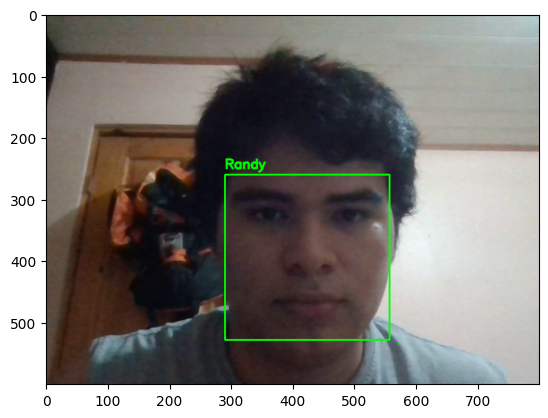

In [82]:
def show_image(image_path, face_info=None):
    """
    This function displays an image with an optional square and name on the face.

    Args:
        image_path (str): Path to the image.
        face_info (tuple): Information about the face (top, right, bottom, left, name).
    """
    img = cv2.imread(image_path)

    if face_info is not None:
        top, right, bottom, left, name = face_info
        # Draw a rectangle around the face
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

        # Add the name above the face
        cv2.putText(
            img,
            name,
            (left, top - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()



def consulta6():
    # Create a dictionary to easily access student, professor, and miscellaneous information by name
    all_people = {}
    for person in registered_student + registered_professor + registered_miscelaneous:
        all_people[person['name']] = person
    course_code = input("Enter the course code: ")
    # Keep track of processed people
    processed_people = set()

    # Iterate through the reported_attendance list
    for attendance in attendance_list0:
        if course_code in attendance:
            attendance_list = attendance[course_code]
            print(f"Course Code: {course_code}")
            for person_info in attendance_list:
                name, img_path, (top, right, bottom, left), attendance_time = person_info

                # Check if the reported person is a student, professor, or miscellaneous
                if name in all_people:
                    person_info = all_people[name]
                    person_type = "Student" if person_info in registered_student else "Professor" if person_info in registered_professor else "Miscellaneous"
                else:
                    person_type = "Unknown"
                    person_info = {}

                # Print all available information from the person's dictionary
                print(f"Type: {person_type}")
                for key, value in person_info.items():
                    print(f"{key.capitalize()}: {value}")
                print(f"Attendance Time: {attendance_time}")
                print()
                show_image(img_path, (top, right, bottom, left, name))
            break
    else:
        print(f"No attendance found for course code: {course_code}")

consulta6()



## Consulta 7

In [83]:

def bubble_sort_by_age(arr):
    n = len(arr)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if arr[j]['age'] > arr[j + 1]['age']:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

def consul7():
    codig = input("Write the code of the course: ")
    enrolled_students = []

    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student information in the same order as enrolled_students
        sorted_students = []

        # Iterate through enrolled students and match the names with registered_student, then append the matching dictionary
        for student_name in enrolled_students:
            for student_dict in registered_student:
                if student_dict['name'] == student_name:
                    sorted_students.append(student_dict)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student information by age using the bubble sort function
        bubble_sort_by_age(sorted_students)

        print("The enrolled students in this course from youngest to oldest are: ")
        for student_info in sorted_students:
            print(f"Name: {student_info['name']}")
            print(f"ID: {student_info['id']}")
            print(f"Age: {student_info['age']}")
            print(f"Birthday: {student_info['Birthday']}")
            print(f"Nationality: {student_info['nationality']}")
            print(f"Phone book: {student_info['Phone book']}")
            print(f"Emails: {student_info['emails']}")
            print(f"Address: {student_info['address']}")
            print(f"Carreer: {student_info['carreer']}")
            print(f"Matiral Status: {student_info['matiral status']}\n")

# Call the function
consul7()



Write the code of the course: PI35
The enrolled students in this course from youngest to oldest are: 
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral Status: Loner

Name: Cristiano
ID: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral Status: Married



## Consulta 8

In [84]:


def insertion_sort_by_age(arr):
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0 and key['age'] > arr[j]['age']:
            arr[j + 1] = arr[j]
            j -= 1
        arr[j + 1] = key

def consul8():
    codig = input("Write the code of the course: ")
    enrolled_students = []

    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student information in the same order as enrolled_students
        sorted_students = []

        # Iterate through enrolled students and match the names with registered_student, then append the matching dictionary
        for student_name in enrolled_students:
            for student_dict in registered_student:
                if student_dict['name'] == student_name:
                    sorted_students.append(student_dict)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student information by age using the insertion sort method
        insertion_sort_by_age(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        for student_info in sorted_students:
            print(f"Name: {student_info['name']}")
            print(f"ID: {student_info['id']}")
            print(f"Age: {student_info['age']}")
            print(f"Birthday: {student_info['Birthday']}")
            print(f"Nationality: {student_info['nationality']}")
            print(f"Phone book: {student_info['Phone book']}")
            print(f"Emails: {student_info['emails']}")
            print(f"Address: {student_info['address']}")
            print(f"Carreer: {student_info['carreer']}")
            print(f"Matiral Status: {student_info['matiral status']}\n")

# Call the function
consul8()


Write the code of the course: PI35
The enrolled students in this course from oldest to youngest are: 
Name: Cristiano
ID: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral Status: Married

Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral Status: Loner



## Consulta 9

In [45]:

def display_student_information(student_name, student_list):
    for student in student_list:
        if student['name'] == student_name:
            student_info = {}
            for key, value in student.items():
                student_info[key.capitalize()] = value
            return student_info  # Return the student information as a dictionary

    return None  # Return None if the student is not found
def leer_mayorasis(lista):
  most_common_name = None
  max_count = 0
  name_counts = {}
  for name in lista:
      if name in name_counts:
          name_counts[name] += 1
      else:
          name_counts[name] = 1
      if name_counts[name] > max_count:
          most_common_name = name
          max_count = name_counts[name]

  return most_common_name

def consul9():
    code = input("Write the code you would like to checkout: ")
    for dictionary in attendance_list2:
        if code in dictionary:
            listofnames = dictionary[code]
            mostcommonperson = leer_mayorasis(listofnames)
    print("The student who assisted the most to this course was: ", mostcommonperson)

    student_info = display_student_information(mostcommonperson, registered_student)
    if student_info:
        print("Student Information:")
        for key, value in student_info.items():
            print(f"{key}: {value}")
    else:
        print(f"No information found for student: {mostcommonperson}")

consul9()



Write the code you would like to checkout: PI35
The student who assisted the most to this course was:  Cristiano
Student Information:
Name: Cristiano
Id: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral status: Married


## Consulta 10

In [86]:

def display_student_information(student_name, student_list):
    for student in student_list:
        if student['name'] == student_name:
            student_info = {}
            for key, value in student.items():
                student_info[key.capitalize()] = value
            return student_info  # Return the student information as a dictionary

    return None  # Return None if the student is not found
def menor_lista(lista):
  least_common_name = None
  min_count = 100000
  name_counts = {}
  for name in lista:
      if name in name_counts:
          name_counts[name] += 1
      else:
          name_counts[name] = 1
  for name, count in name_counts.items():
      if count < min_count:
          least_common_name = name
          min_count = count
  return least_common_name

def consul10():
    code = input("Write the code you would like to checkout: ")
    for dictionary in attendance_list2:
        if code in dictionary:
            listofnames = dictionary[code]
            leastcommonperson = menor_lista(listofnames)
    print("The student who assisted the least to this course was: ", leastcommonperson)

    student_info = display_student_information(leastcommonperson, registered_student)
    if student_info:
        print("Student Information:")
        for key, value in student_info.items():
            print(f"{key}: {value}")
    else:
        print(f"No information found for student: {leastcommonperson}")

consul10()

Write the code you would like to checkout: IC001
The student who assisted the least to this course was:  Randy
Student Information:
Name: Randy
Id: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral status: Loner


## Consulta 11

Enter the course code: PI35
The time with the most attendees for course PI35: 2023-10-03 10:12
Number of attendees at that time: 3
Attendees' Information:

Type: Professor
Name: Messi
Id: 8588586
Age: 36
Birthday: 73736
Nationality: Argentinian
Phone book: {'msus': '477488'}
Emails: ['messias@gmail.com']
Address: sididnid
Specialty: Dribbles
Matiral status: Married
Attendance Time: 2023-10-03 10:12


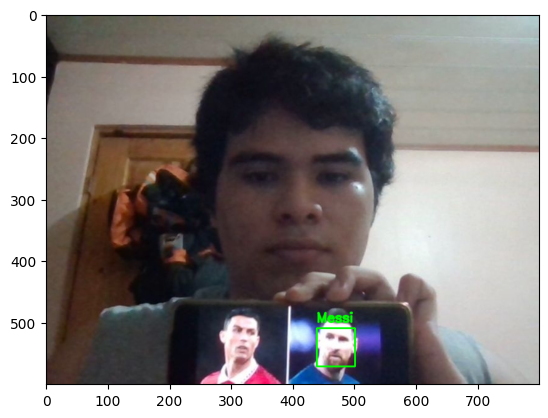


Type: Student
Name: Randy
Id: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral status: Loner
Attendance Time: 2023-10-03 10:12


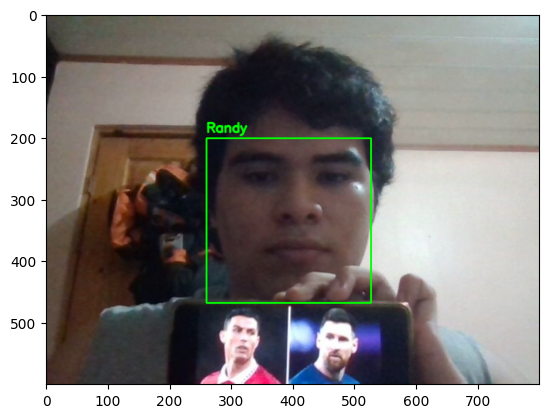


Type: Student
Name: Cristiano
Id: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral status: Married
Attendance Time: 2023-10-03 10:12


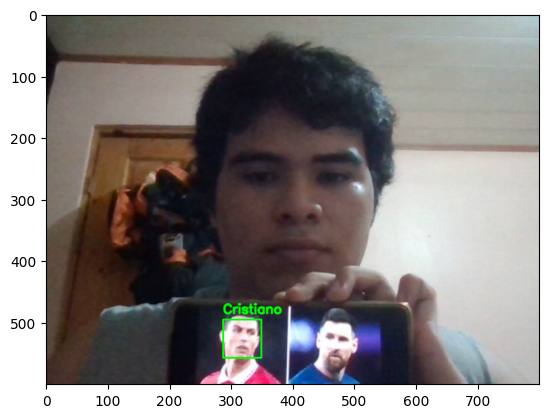

In [99]:
def consulta11():
    # Create a dictionary to easily access student, professor, and miscellaneous information by name
    all_people = {}
    for person in registered_student + registered_professor + registered_miscelaneous:
        all_people[person['name']] = person
    course_code = input("Enter the course code: ")

    # Dictionary to store attendance counts for each time slot
    time_slot_counts = {}

    # Iterate through the reported_attendance list
    for attendance in attendance_list3:
        for time_slot, attendance_data in attendance.items():
            if course_code in attendance_data:
                attendance_count = len(attendance_data[course_code])
                time_slot_counts[time_slot] = attendance_count

    # Find the time slot with the most attendees
    max_attendance_time = max(time_slot_counts, key=time_slot_counts.get)
    max_attendance_count = time_slot_counts[max_attendance_time]

    if max_attendance_time:
        print(f"The time with the most attendees for course {course_code}: {max_attendance_time}")
        print(f"Number of attendees at that time: {max_attendance_count}")
        print("Attendees' Information:")

        # Iterate through attendance_list0 to find attendees at the specified time
        for attendance_data in attendance_list0:
            if course_code in attendance_data:
                attendance_list = attendance_data[course_code]

                # Iterate through attendees and display their information
                for person_info in attendance_list:
                    name, img_path, (top, right, bottom, left), attendance_time = person_info

                    # Check if the reported person is a student, professor, or miscellaneous
                    if name in all_people:
                        person_info = all_people[name]
                        person_type = "Student" if person_info in registered_student else "Professor" if person_info in registered_professor else "Miscellaneous"
                    else:
                        person_type = "Unknown"
                        person_info = {}

                    # Print all available information from the person's dictionary
                    print(f"\nType: {person_type}")
                    for key, value in person_info.items():
                        print(f"{key.capitalize()}: {value}")
                    print(f"Attendance Time: {attendance_time}")

                    # Display the image with a square on the face and the person's name
                    show_image(img_path, (top, right, bottom, left, name))

    else:
        print(f"No attendance records found for course code: {course_code}")

# Call the function
consulta11()


## Consulta 12

In [89]:


def quicksort(arr):
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        less = [x for x in arr[1:] if x['age'] <= pivot['age']]
        greater = [x for x in arr[1:] if x['age'] > pivot['age']]
        return quicksort(greater) + [pivot] + quicksort(less)

def consul12():
    codig = input("Write the code of the course: ")
    enrolled_students = []

    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student information in the same order as enrolled_students
        sorted_students = []

        # Iterate through enrolled students and match the names with registered_student, then append the matching dictionary
        for student_name in enrolled_students:
            for student_dict in registered_student:
                if student_dict['name'] == student_name:
                    sorted_students.append(student_dict)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student information by age using the quicksort method
        sorted_students = quicksort(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        for student_info in sorted_students:
            print(f"Name: {student_info['name']}")
            print(f"ID: {student_info['id']}")
            print(f"Age: {student_info['age']}")
            print(f"Birthday: {student_info['Birthday']}")
            print(f"Nationality: {student_info['nationality']}")
            print(f"Phone book: {student_info['Phone book']}")
            print(f"Emails: {student_info['emails']}")
            print(f"Address: {student_info['address']}")
            print(f"Carreer: {student_info['carreer']}")
            print(f"Matiral Status: {student_info['matiral status']}\n")

# Call the function
consul12()


Write the code of the course: PI35
The enrolled students in this course from oldest to youngest are: 
Name: Cristiano
ID: 36362627
Age: 28
Birthday: 83874
Nationality: Portugues
Phone book: {'jsjdb': '82626637'}
Emails: ['sjjeie@gmail.com']
Address: jdhdhdhe
Carreer: Ing computacion
Matiral Status: Married

Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book: {'snf': '8575574'}
Emails: ['siroko147@gmail.com']
Address: eifinie
Carreer: Ing computacion
Matiral Status: Loner



# Link de imagenes utilizadas y obtenidas

[Link a la carpeta de imagenes usadas e imagenes obtenidas](https://drive.google.com/drive/folders/1hA7QlFRvi8RJiykNM1jvPJhhH7FZoKPp?usp=sharing)